# Subtask 1:
## Statistics

In [1]:
import pandas as pd         # data handling
#import matplotlib           # histogram plotting
import matplotlib.pyplot as plt

candidatesFileName = 'files/candidates_V2.csv'
#candidatesnp = np.genfromtxt('.candidates_V2.csv', delimiter=',', dtype=None, skip_header=0)
candidates = pd.read_csv(candidatesFileName)

candidates

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0
...,...,...,...,...,...
754970,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-33.400000,-64.200000,-115.560000,0
754971,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,56.236359,70.352400,-203.446236,0
754972,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-97.104221,55.738289,-203.879785,0
754973,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-65.470000,59.670000,-136.370000,0


The total number of scans is 754975.
There are 888 different UIDs.
There are 753418 non nodules and 1557 nodules.


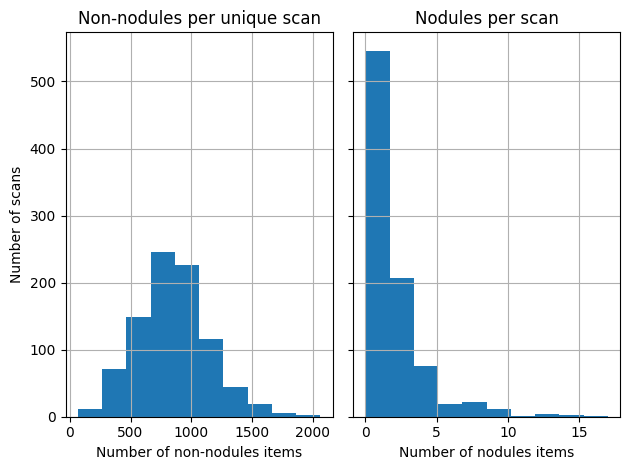

In [2]:
print("The total number of scans is " + str(len(candidates)) + ".")
print("There are " + str(candidates['seriesuid'].nunique()) + " different UIDs.")
nNonnodules = str(candidates['class'].value_counts()[0])
nNodules = str(candidates['class'].value_counts()[1])
print("There are " + nNonnodules + " non nodules and " +
      nNodules + " nodules.")

counts = candidates.groupby(['seriesuid', 'class']).size().unstack(fill_value=0)
#counts.hist(legend=True)

fig, axes = plt.subplots(1, 2, sharey=True)
counts[0].hist( ax=axes[0])
axes[0].set_title('Non-nodules per unique scan')
axes[0].set_xlabel('Number of non-nodules items')
axes[0].set_ylabel('Number of scans')

counts[1].hist( ax=axes[1])
axes[1].set_title('Nodules per scan')
axes[1].set_xlabel('Number of nodules items')

plt.tight_layout()
plt.show()

## Loading

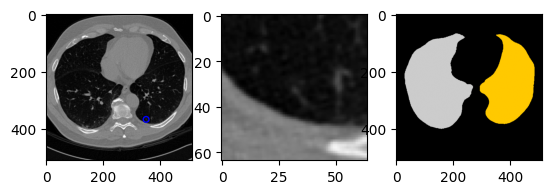

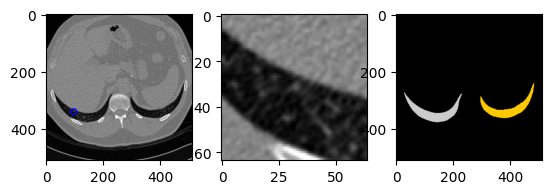

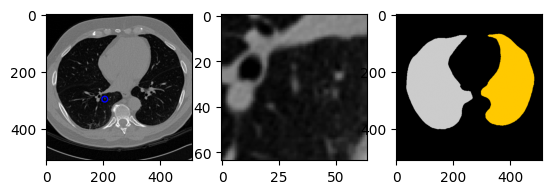

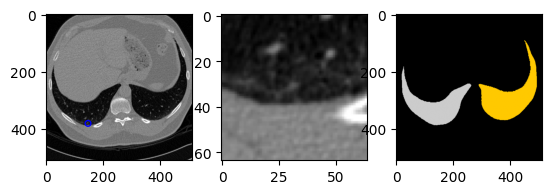

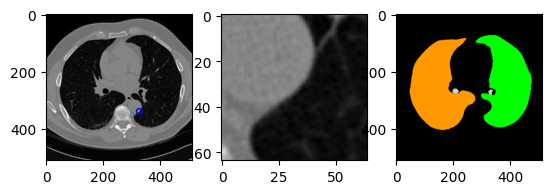

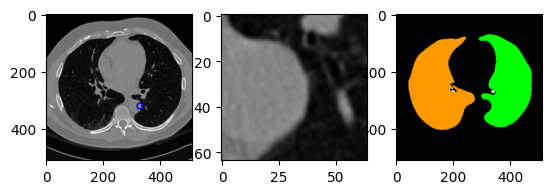

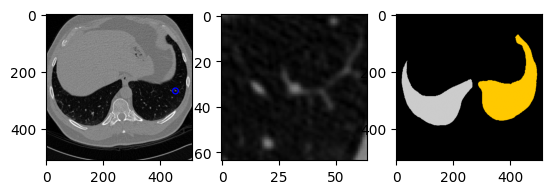

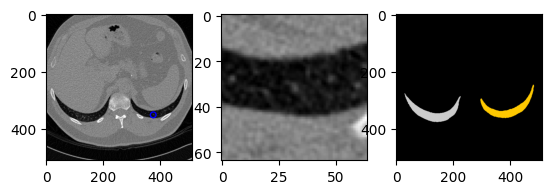

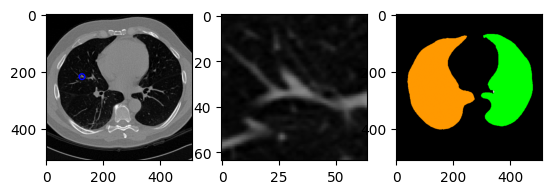

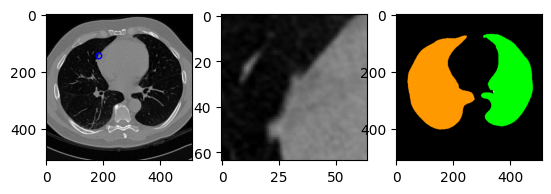

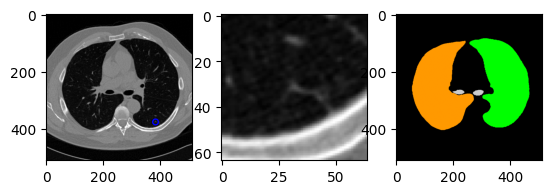

In [19]:
import numpy as np
import itk
import matplotlib.pyplot as plt
import scipy.misc



scan_path = "files/subset/scans/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd"
mhd_data = itk.imread(scan_path)

segment_path = "files/subset/segments/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd"
mhd_data_segment = itk.imread(segment_path)

# convert to numpy array
scan = np.array(itk.GetArrayFromImage(mhd_data), dtype=np.float32)
scan_segment = np.array(itk.GetArrayFromImage(mhd_data_segment), dtype=np.float32)
clip_win = (-1000, 1000)
scan.clip(clip_win[0], clip_win[1], scan)  # clip to reasonable HU values

origin_xyz = np.asarray(mhd_data.GetOrigin())
voxel_size_xyz = np.asarray(mhd_data.GetSpacing())
#voxel_size_xyz = mhd_data.GetSpacing()
direction_matrix = np.asarray(mhd_data.GetDirection()).reshape(3, 3) # changed to asarray from array to fix type error

matchingc = candidates[candidates['seriesuid'] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860"]

#nodulecandidates = matchingc[matchingc['class'] == 1]

c = {0: 'b', 1: 'r'} # dict

n=0
for (_,i) in matchingc.iterrows():
    n = n+1
    # Get world coordinates
    world_coords = i.loc[['coordX', 'coordY', 'coordZ']].to_numpy(dtype=np.float32)
    # Transformation into voxel ("pixel") coordinates
    voxel_coords = np.linalg.inv(direction_matrix) @ ((world_coords - origin_xyz)/voxel_size_xyz)
    voxel_coords_rounded = np.int16(voxel_coords.round(0))

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    
    plt.subplot(1,3,1)
    plt.imshow(scan[voxel_coords_rounded[2], :, :], cmap=plt.cm.gray)
    nod_coords = (voxel_coords_rounded[0], voxel_coords_rounded[1])
    ax1.add_patch(plt.Circle(nod_coords, 10, color=c[i["class"]], fill=False))

    plt.subplot(1,3,2)
    slice = scan[voxel_coords_rounded[2], :, :]
    
    slicebox = np.array([(nod_coords[1]-32), (nod_coords[1]+32), (nod_coords[0]-32), (nod_coords[0]+32)])
    if (np.any(slicebox < 0) or np.any(slicebox > 512)):
        continue
    extracted_patch = slice[(nod_coords[1]-32):(nod_coords[1]+32), (nod_coords[0]-32):(nod_coords[0]+32)]
    plt.imshow(extracted_patch, cmap=plt.cm.gray, vmin=clip_win[0], vmax=clip_win[1])
    #plt.savefig('output.png')
    plt.imsave('output.png', extracted_patch, cmap=plt.cm.gray, vmin=clip_win[0], vmax=clip_win[1])
    
    plt.subplot(1,3,3)
    plt.imshow(scan_segment[voxel_coords_rounded[2], :, :], cmap=plt.cm.nipy_spectral)
    if n > 10:
        break
    


In [14]:
clip_win = (-1000, 1000)
clip_win[0]

-1000